In [8]:
# ============================
# IMPORTAÇÕES
# ============================

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

sns.set(style="whitegrid")

print("✓ Todos os pacotes importados com sucesso!")

# Verificar versões
print(f"\nVersões instaladas:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"sklearn: {sklearn.__version__}")

✓ Todos os pacotes importados com sucesso!

Versões instaladas:
pandas: 3.0.1
numpy: 2.4.2
matplotlib: 3.10.8
seaborn: 0.13.2
sklearn: 1.8.0


In [9]:
# ============================
# CARREGAR PLANILHA
# ============================

df = pd.read_excel("projetos_completos_final.xlsx")
df.head()

,guid,nome_projeto,subsecretaria,status_atual_do_projeto,questoes_chaves,proximas_etapas,status_dos_estudos,status_consulta_publica,status_do_tcu,status_do_edital,...,custo_estimado,moeda,custo_original,status_atividade,eh_ppp,tipo_projeto,arranjo_contratual,processo_licitacao,outro_arranjo_contratual,outro_processo_licitacao
0,01fb8247-91ec-4631-bf1f-3da9fa6822d6,Projeto 01fb8247,SIEC,Relatório final aprovado pela ANTT em 29/01/26...,NaN,NaN,Completed,Completed,NaN,NaN,...,2.605232e+09,BRL,14000000000,Active,True,Refurbishment/Replacement,Concession: Law 8.987/95,NaN,NaN,NaN
1,022ea245-c8f4-440a-9a1b-2aa0e2f523fd,Projeto 022ea245,SISU,Estudos em andamento,Delegações do serviço embarcado\nPossibilidade...,Conclusão dos estudos\nRealizar Consulta/Audiê...,NaN,NaN,NaN,NaN,...,1.817490e-01,BRL,1,Active,True,New,Concession: Law 8.987/95,NaN,NaN,NaN
2,03175202-1983-4ce9-9425-f8271bf2e138,Projeto 03175202,SIEC,NaN,NaN,NaN,In progress,Not started,Not started,Not started,...,0.000000e+00,BRL,1,NaN,True,Refurbishment/Replacement,Concession: Law 8.987/95,Competition,NaN,NaN
3,03476266-e9a1-4821-8179-8abd15903f7b,Projeto 03476266,SIEC,NaN,NaN,NaN,Completed,Completed,Not started,Not started,...,2.552000e+09,BRL,14500000000,Active,True,New,"Extension: Law 13.448/17, Art. 4, I and II",Competition,NaN,NaN
4,07fb13d8-0616-41f8-ab50-99c1c6669fd7,Projeto 07fb13d8,SIEC,NaN,NaN,NaN,Completed,Completed,Completed,Completed,...,3.719562e+06,BRL,21133873,NaN,True,Refurbishment/Replacement,Concession: Law 8.987/95,Competition,NaN,NaN


In [10]:
# ============================
# SELEÇÃO DE VARIÁVEIS
# ============================

features = [
    "custo_estimado",
    "eh_ppp",
    "tipo_projeto",
    "arranjo_contratual",
    "processo_licitacao",
    "setor",
    "subsetor",
    "organizacao"
]

df_cluster = df[features].copy()

df_cluster.head()

,custo_estimado,eh_ppp,tipo_projeto,arranjo_contratual,processo_licitacao,setor,subsetor,organizacao
0,2.605232e+09,True,Refurbishment/Replacement,Concession: Law 8.987/95,NaN,Transport,Highway,SEPPI
1,1.817490e-01,True,New,Concession: Law 8.987/95,NaN,Other,Other,SEPPI
2,0.000000e+00,True,Refurbishment/Replacement,Concession: Law 8.987/95,Competition,Transport,Seaport,SEPPI
3,2.552000e+09,True,New,"Extension: Law 13.448/17, Art. 4, I and II",Competition,Transport,Intercity Rail,SEPPI
4,3.719562e+06,True,Refurbishment/Replacement,Concession: Law 8.987/95,Competition,Transport,Seaport,SEPPI


In [11]:
# ============================
# TRATAMENTO DE NULOS
# ============================

# Numérica
df_cluster["custo_estimado"] = df_cluster["custo_estimado"].fillna(
    df_cluster["custo_estimado"].median()
)

# Categóricas
for col in df_cluster.columns:
    if df_cluster[col].dtype == "object":
        df_cluster[col] = df_cluster[col].fillna("Desconhecido")

df_cluster.isna().sum()

custo_estimado         0
eh_ppp                 0
tipo_projeto           0
arranjo_contratual    14
processo_licitacao    25
setor                  0
subsetor               0
organizacao            1
dtype: int64

In [12]:
# ============================
# PRÉ-PROCESSAMENTO
# ============================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_features = ["custo_estimado"]
categorical_features = [
    "eh_ppp",
    "tipo_projeto",
    "arranjo_contratual",
    "processo_licitacao",
    "setor",
    "subsetor",
    "organizacao"
]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_processed = preprocess.fit_transform(df_cluster)

X_processed.shape

(209, 41)

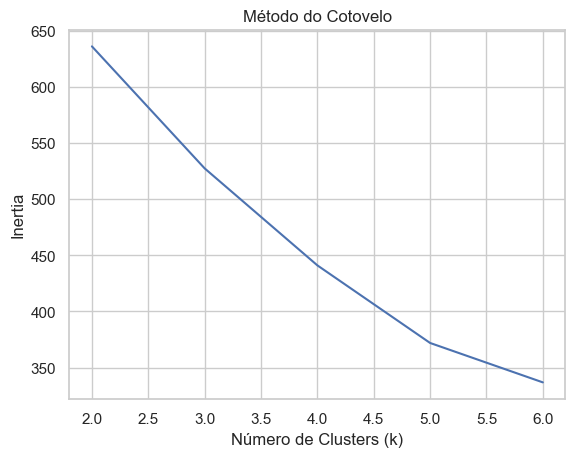

In [13]:
# ============================
# MÉTODO DO COTOVELO
# ============================

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 7), inertia)
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inertia")
plt.title("Método do Cotovelo")
plt.show()

In [14]:
# ============================
# SILHOUETTE SCORE
# ============================

from sklearn.metrics import silhouette_score

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    print(f"k={k} → Silhouette Score: {score:.4f}")

k=2 → Silhouette Score: 0.5247
k=3 → Silhouette Score: 0.2289
k=4 → Silhouette Score: 0.2782
k=5 → Silhouette Score: 0.3568
k=6 → Silhouette Score: 0.3461


In [15]:
# ============================
# TREINAMENTO FINAL
# ============================

k_final = 3

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df_cluster["cluster"] = kmeans_final.fit_predict(X_processed)

df_cluster["cluster"].value_counts()

cluster
0    132
2     68
1      9
Name: count, dtype: int64

In [16]:
# ============================
# ANÁLISE DOS CLUSTERS
# ============================

df_analysis = df_cluster.copy()

summary = df_analysis.groupby("cluster").agg({
    "custo_estimado": ["mean", "median", "count"],
    "eh_ppp": lambda x: (x == True).mean()
})

summary

custo_estimado                       eh_ppp
                  mean        median count <lambda>
cluster                                            
0         1.367506e+08  3.736722e+06   132      1.0
1         3.484000e+09  3.330800e+09     9      1.0
2         1.104576e+08  1.533569e+07    68      1.0

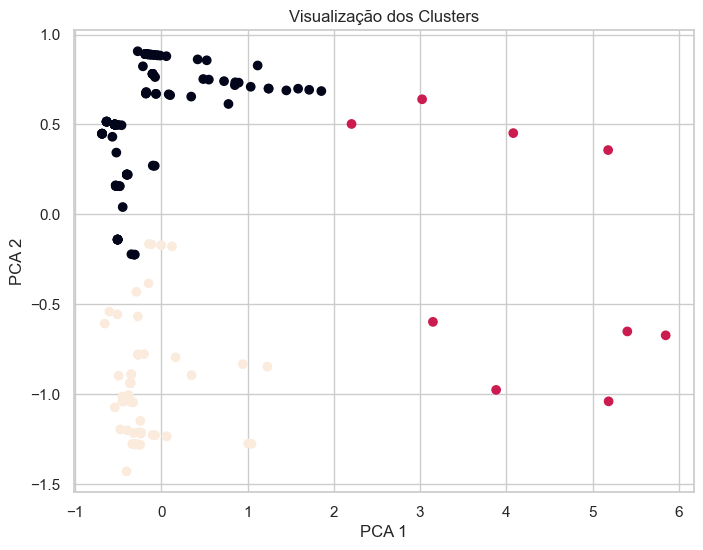

In [17]:
# ============================
# VISUALIZAÇÃO 2D (PCA)
# ============================

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_cluster["cluster"])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Visualização dos Clusters")
plt.show()

In [18]:
import pandas as pd

df = pd.read_excel("projetos_completos_final.xlsx")

df.head()

,guid,nome_projeto,subsecretaria,status_atual_do_projeto,questoes_chaves,proximas_etapas,status_dos_estudos,status_consulta_publica,status_do_tcu,status_do_edital,...,custo_estimado,moeda,custo_original,status_atividade,eh_ppp,tipo_projeto,arranjo_contratual,processo_licitacao,outro_arranjo_contratual,outro_processo_licitacao
0,01fb8247-91ec-4631-bf1f-3da9fa6822d6,Projeto 01fb8247,SIEC,Relatório final aprovado pela ANTT em 29/01/26...,NaN,NaN,Completed,Completed,NaN,NaN,...,2.605232e+09,BRL,14000000000,Active,True,Refurbishment/Replacement,Concession: Law 8.987/95,NaN,NaN,NaN
1,022ea245-c8f4-440a-9a1b-2aa0e2f523fd,Projeto 022ea245,SISU,Estudos em andamento,Delegações do serviço embarcado\nPossibilidade...,Conclusão dos estudos\nRealizar Consulta/Audiê...,NaN,NaN,NaN,NaN,...,1.817490e-01,BRL,1,Active,True,New,Concession: Law 8.987/95,NaN,NaN,NaN
2,03175202-1983-4ce9-9425-f8271bf2e138,Projeto 03175202,SIEC,NaN,NaN,NaN,In progress,Not started,Not started,Not started,...,0.000000e+00,BRL,1,NaN,True,Refurbishment/Replacement,Concession: Law 8.987/95,Competition,NaN,NaN
3,03476266-e9a1-4821-8179-8abd15903f7b,Projeto 03476266,SIEC,NaN,NaN,NaN,Completed,Completed,Not started,Not started,...,2.552000e+09,BRL,14500000000,Active,True,New,"Extension: Law 13.448/17, Art. 4, I and II",Competition,NaN,NaN
4,07fb13d8-0616-41f8-ab50-99c1c6669fd7,Projeto 07fb13d8,SIEC,NaN,NaN,NaN,Completed,Completed,Completed,Completed,...,3.719562e+06,BRL,21133873,NaN,True,Refurbishment/Replacement,Concession: Law 8.987/95,Competition,NaN,NaN


In [19]:
for col in df.columns:
    print(f"'{col}'")

'guid'
'nome_projeto'
'subsecretaria'
'status_atual_do_projeto'
'questoes_chaves'
'proximas_etapas'
'status_dos_estudos'
'status_consulta_publica'
'status_do_tcu'
'status_do_edital'
'status_do_leilao'
'status_do_contrato'
'descricao_do_projeto'
'nome_completo'
'descricao_curta'
'setor'
'subsetor'
'organizacao'
'localizacoes'
'latitude'
'longitude'
'endereco_principal'
'custo_estimado'
'moeda'
'custo_original'
'status_atividade'
'eh_ppp'
'tipo_projeto'
'arranjo_contratual'
'processo_licitacao'
'outro_arranjo_contratual'
'outro_processo_licitacao'


In [20]:
import re
import numpy as np

def extrair_percentual(texto):
    if pd.isna(texto):
        return np.nan
    
    match = re.search(r'(\d{1,3})\s*%', str(texto))
    if match:
        return float(match.group(1))
    
    return np.nan

df["percentual_execucao"] = df["status_atual_do_projeto"].apply(extrair_percentual)

df["percentual_execucao"].describe()

count    27.000000
mean     62.629630
std      26.874564
min       7.000000
25%      46.000000
50%      71.000000
75%      83.500000
max      99.000000
Name: percentual_execucao, dtype: float64

In [21]:
import re
import numpy as np

def extrair_percentual(texto):
    if pd.isna(texto):
        return np.nan
    match = re.search(r'(\d{1,3})\s*%', str(texto))
    if match:
        return float(match.group(1))
    return np.nan

df["percentual_execucao"] = df["status_atual_do_projeto"].apply(extrair_percentual)

In [22]:
df["custo_estimado"] = pd.to_numeric(df["custo_estimado"], errors="coerce")

In [23]:
import re
import numpy as np

def extrair_percentual(texto):
    if pd.isna(texto):
        return np.nan
    match = re.search(r'(\d{1,3})\s*%', str(texto))
    if match:
        return float(match.group(1))
    return np.nan

df["percentual_execucao"] = df["status_atual_do_projeto"].apply(extrair_percentual)

In [24]:
df["custo_estimado"] = pd.to_numeric(df["custo_estimado"], errors="coerce")

In [25]:
from sklearn.preprocessing import StandardScaler

features_cluster = df[["percentual_execucao", "custo_estimado"]].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_cluster)

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

features_cluster["cluster"] = clusters

In [27]:
df.loc[features_cluster.index, "cluster"] = clusters

In [28]:
df.groupby("cluster")["percentual_execucao"].mean()

cluster
0.0    82.333333
1.0    15.000000
2.0    45.666667
Name: percentual_execucao, dtype: float64

In [29]:
y = df["cluster"]

In [30]:
df.columns.tolist()

['guid',
 'nome_projeto',
 'subsecretaria',
 'status_atual_do_projeto',
 'questoes_chaves',
 'proximas_etapas',
 'status_dos_estudos',
 'status_consulta_publica',
 'status_do_tcu',
 'status_do_edital',
 'status_do_leilao',
 'status_do_contrato',
 'descricao_do_projeto',
 'nome_completo',
 'descricao_curta',
 'setor',
 'subsetor',
 'organizacao',
 'localizacoes',
 'latitude',
 'longitude',
 'endereco_principal',
 'custo_estimado',
 'moeda',
 'custo_original',
 'status_atividade',
 'eh_ppp',
 'tipo_projeto',
 'arranjo_contratual',
 'processo_licitacao',
 'outro_arranjo_contratual',
 'outro_processo_licitacao',
 'percentual_execucao',
 'cluster']

In [31]:
# Garantir que não há espaços invisíveis
df.columns = df.columns.str.strip()

# Trabalhar apenas com linhas que possuem cluster
df_model = df.dropna(subset=["cluster"]).copy()

y = df_model["cluster"]

features = [
    "setor",
    "subsetor",
    "arranjo_contratual",
    "processo_licitacao",
    "custo_estimado"
]

X = df_model[features]

print("Features utilizadas:", features)
print("Shape:", X.shape)

Features utilizadas: ['setor', 'subsetor', 'arranjo_contratual', 'processo_licitacao', 'custo_estimado']
Shape: (27, 5)


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

num_cols = ["custo_estimado"]
cat_cols = ["setor", "subsetor", "arranjo_contratual", "processo_licitacao"]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", model)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.83      0.77         6
         1.0       0.00      0.00      0.00         0
         2.0       1.00      0.33      0.50         3

    accuracy                           0.67         9
   macro avg       0.57      0.39      0.42         9
weighted avg       0.81      0.67      0.68         9



c:\Users\carlos.ramos\OneDrive - Presidência da República\Área de Trabalho\Painel-Projetos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\carlos.ramos\OneDrive - Presidência da República\Área de Trabalho\Painel-Projetos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\carlos.ramos\OneDrive - Presidência da República\Área de Trabalho\Painel-Projetos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 i

In [33]:
from sklearn.preprocessing import MinMaxScaler

score_features = df[["percentual_execucao", "custo_estimado"]].copy()

score_features = score_features.fillna(score_features.median())

scaler = MinMaxScaler()

scaled = scaler.fit_transform(score_features)

df["score_maturidade"] = scaled.mean(axis=1)

df["score_maturidade"].describe()

count    209.000000
mean       0.370555
std        0.093616
min        0.010278
25%        0.347826
50%        0.348527
75%        0.362615
max        0.847826
Name: score_maturidade, dtype: float64

In [34]:
def classificar_score(score):
    if score < 0.33:
        return "Baixa"
    elif score < 0.66:
        return "Média"
    else:
        return "Alta"

df["categoria_maturidade"] = df["score_maturidade"].apply(classificar_score)

df["categoria_maturidade"].value_counts()

categoria_maturidade
Média    191
Baixa     12
Alta       6
Name: count, dtype: int64

In [35]:
df["atraso_flag"] = (
    (df["percentual_execucao"] < 40) &
    (df["status_do_contrato"].isna())
).astype(int)

df["atraso_flag"].value_counts()

atraso_flag
0    205
1      4
Name: count, dtype: int64

In [36]:
y_atraso = df["atraso_flag"]
X_atraso = df[features]

X_train, X_test, y_train, y_test = train_test_split(
    X_atraso, y_atraso, test_size=0.3, random_state=42
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        62
           1       0.00      0.00      0.00         1

    accuracy                           0.94        63
   macro avg       0.49      0.48      0.48        63
weighted avg       0.97      0.94      0.95        63



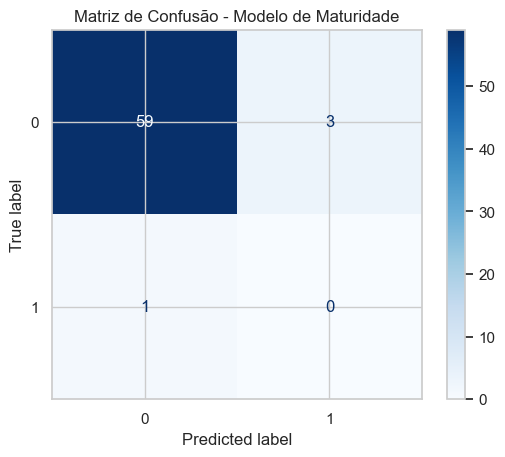

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Modelo de Maturidade")
plt.show()

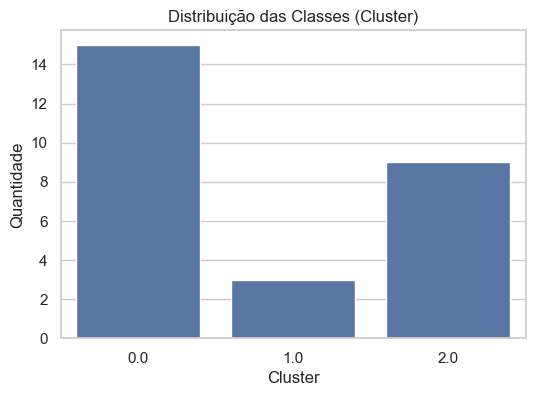

In [38]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Distribuição das Classes (Cluster)")
plt.xlabel("Cluster")
plt.ylabel("Quantidade")
plt.show()

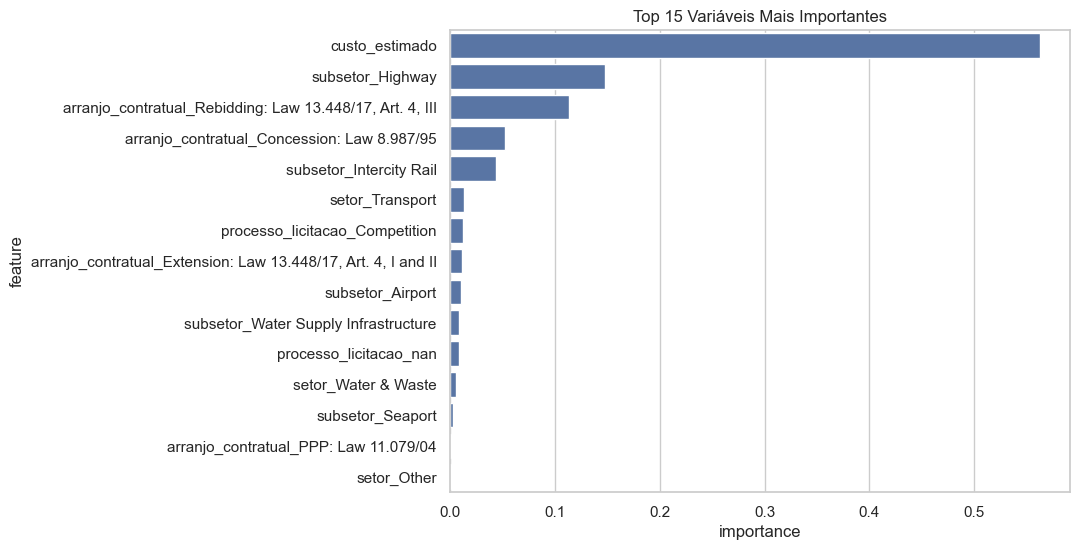

In [39]:
import numpy as np

# Extrair nomes das colunas após OneHotEncoder
ohe = pipe.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = num_cols + list(cat_feature_names)

importances = pipe.named_steps["model"].feature_importances_

feat_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(15)
)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp, x="importance", y="feature")
plt.title("Top 15 Variáveis Mais Importantes")
plt.show()

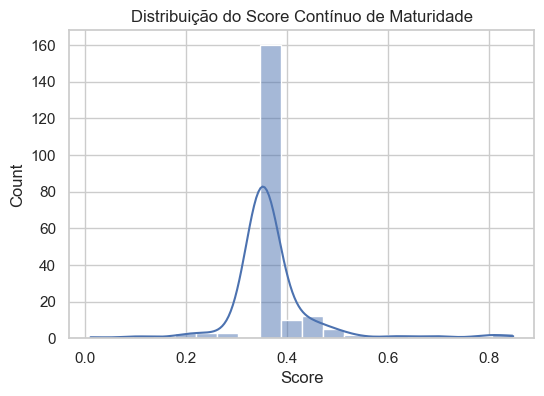

In [40]:
plt.figure(figsize=(6,4))
sns.histplot(df["score_maturidade"], bins=20, kde=True)
plt.title("Distribuição do Score Contínuo de Maturidade")
plt.xlabel("Score")
plt.show()

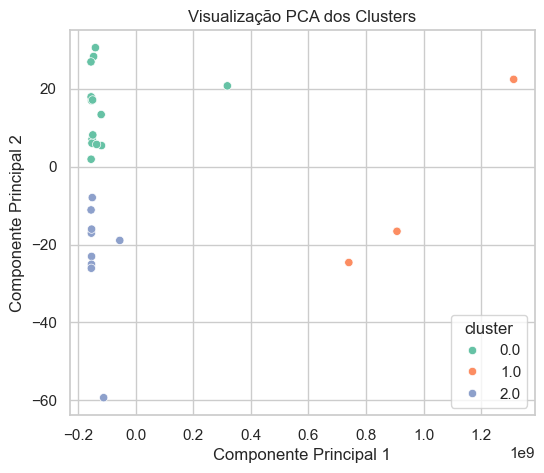

In [41]:
from sklearn.decomposition import PCA

X_cluster = df_model[["percentual_execucao", "custo_estimado"]].fillna(0)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df_model["cluster"],
    palette="Set2"
)
plt.title("Visualização PCA dos Clusters")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

In [42]:
import pandas as pd
import numpy as np

df_cluster2 = df.copy()

status_cols = [
    'status_dos_estudos',
    'status_consulta_publica',
    'status_do_tcu',
    'status_do_edital',
    'status_do_leilao',
    'status_do_contrato'
]

# Transformar categorias em números (ordinal simples)
for col in status_cols:
    df_cluster2[col] = df_cluster2[col].astype("category").cat.codes

# Criar score médio estrutural
df_cluster2["score_estrutura"] = df_cluster2[status_cols].mean(axis=1)

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features_sem_custo = df_cluster2[[
    'percentual_execucao',
    'score_estrutura'
]].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_sem_custo)

kmeans2 = KMeans(n_clusters=3, random_state=42)
df_cluster2["cluster_sem_custo"] = kmeans2.fit_predict(X_scaled)

In [44]:
df_cluster2.groupby("cluster_sem_custo")[[
    "percentual_execucao",
    "score_estrutura"
]].mean()

,percentual_execucao,score_estrutura
cluster_sem_custo,,
0,71.217391,0.717391
1,15.000000,-0.711538
2,8.000000,0.914179


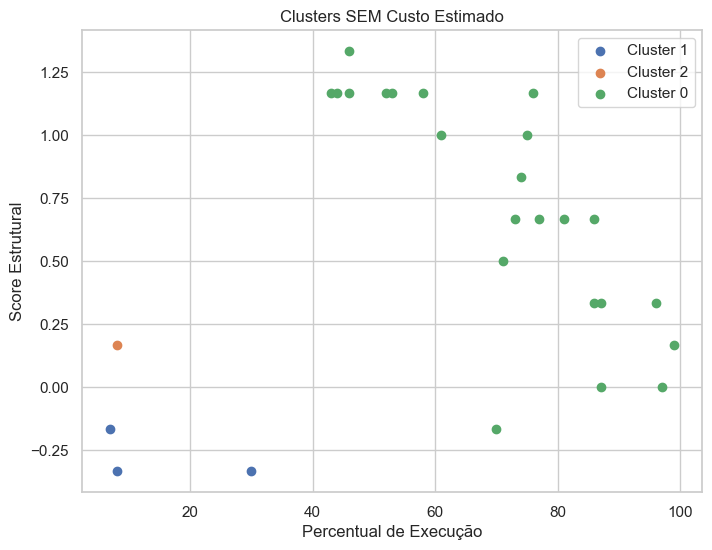

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for c in df_cluster2["cluster_sem_custo"].unique():
    subset = df_cluster2[df_cluster2["cluster_sem_custo"] == c]
    plt.scatter(
        subset["percentual_execucao"],
        subset["score_estrutura"],
        label=f"Cluster {c}"
    )

plt.xlabel("Percentual de Execução")
plt.ylabel("Score Estrutural")
plt.legend()
plt.title("Clusters SEM Custo Estimado")
plt.show()

In [46]:
pd.crosstab(
    df["cluster"],
    df_cluster2["cluster_sem_custo"],
    normalize="index"
)

cluster_sem_custo,0,1,2
cluster,,,
0.0,1.000000,0.0,0.000000
1.0,0.000000,1.0,0.000000
2.0,0.888889,0.0,0.111111


In [47]:
import pandas as pd

# Caminho do seu arquivo
df = pd.read_excel("projetos_completos_final.xlsx")  # ou .csv

df.head()

,guid,nome_projeto,subsecretaria,status_atual_do_projeto,questoes_chaves,proximas_etapas,status_dos_estudos,status_consulta_publica,status_do_tcu,status_do_edital,...,custo_estimado,moeda,custo_original,status_atividade,eh_ppp,tipo_projeto,arranjo_contratual,processo_licitacao,outro_arranjo_contratual,outro_processo_licitacao
0,01fb8247-91ec-4631-bf1f-3da9fa6822d6,Projeto 01fb8247,SIEC,Relatório final aprovado pela ANTT em 29/01/26...,NaN,NaN,Completed,Completed,NaN,NaN,...,2.605232e+09,BRL,14000000000,Active,True,Refurbishment/Replacement,Concession: Law 8.987/95,NaN,NaN,NaN
1,022ea245-c8f4-440a-9a1b-2aa0e2f523fd,Projeto 022ea245,SISU,Estudos em andamento,Delegações do serviço embarcado\nPossibilidade...,Conclusão dos estudos\nRealizar Consulta/Audiê...,NaN,NaN,NaN,NaN,...,1.817490e-01,BRL,1,Active,True,New,Concession: Law 8.987/95,NaN,NaN,NaN
2,03175202-1983-4ce9-9425-f8271bf2e138,Projeto 03175202,SIEC,NaN,NaN,NaN,In progress,Not started,Not started,Not started,...,0.000000e+00,BRL,1,NaN,True,Refurbishment/Replacement,Concession: Law 8.987/95,Competition,NaN,NaN
3,03476266-e9a1-4821-8179-8abd15903f7b,Projeto 03476266,SIEC,NaN,NaN,NaN,Completed,Completed,Not started,Not started,...,2.552000e+09,BRL,14500000000,Active,True,New,"Extension: Law 13.448/17, Art. 4, I and II",Competition,NaN,NaN
4,07fb13d8-0616-41f8-ab50-99c1c6669fd7,Projeto 07fb13d8,SIEC,NaN,NaN,NaN,Completed,Completed,Completed,Completed,...,3.719562e+06,BRL,21133873,NaN,True,Refurbishment/Replacement,Concession: Law 8.987/95,Competition,NaN,NaN


In [49]:
df.columns.tolist()

['guid',
 'nome_projeto',
 'subsecretaria',
 'status_atual_do_projeto',
 'questoes_chaves',
 'proximas_etapas',
 'status_dos_estudos',
 'status_consulta_publica',
 'status_do_tcu',
 'status_do_edital',
 'status_do_leilao',
 'status_do_contrato',
 'descricao_do_projeto',
 'nome_completo',
 'descricao_curta',
 'setor',
 'subsetor',
 'organizacao',
 'localizacoes',
 'latitude',
 'longitude',
 'endereco_principal',
 'custo_estimado',
 'moeda',
 'custo_original',
 'status_atividade',
 'eh_ppp',
 'tipo_projeto',
 'arranjo_contratual',
 'processo_licitacao',
 'outro_arranjo_contratual',
 'outro_processo_licitacao',
 'cluster_sem_custo']

In [51]:
for col in df.columns:
    print(col)

guid
nome_projeto
subsecretaria
status_atual_do_projeto
questoes_chaves
proximas_etapas
status_dos_estudos
status_consulta_publica
status_do_tcu
status_do_edital
status_do_leilao
status_do_contrato
descricao_do_projeto
nome_completo
descricao_curta
setor
subsetor
organizacao
localizacoes
latitude
longitude
endereco_principal
custo_estimado
moeda
custo_original
status_atividade
eh_ppp
tipo_projeto
arranjo_contratual
processo_licitacao
outro_arranjo_contratual
outro_processo_licitacao
cluster_sem_custo


In [52]:
features_cluster = [
    "percentual execução",
    "custo_estimado"
]

In [54]:
df.head()

,guid,nome_projeto,subsecretaria,status_atual_do_projeto,questoes_chaves,proximas_etapas,status_dos_estudos,status_consulta_publica,status_do_tcu,status_do_edital,...,moeda,custo_original,status_atividade,eh_ppp,tipo_projeto,arranjo_contratual,processo_licitacao,outro_arranjo_contratual,outro_processo_licitacao,cluster_sem_custo
0,01fb8247-91ec-4631-bf1f-3da9fa6822d6,Projeto 01fb8247,SIEC,Relatório final aprovado pela ANTT em 29/01/26...,NaN,NaN,Completed,Completed,NaN,NaN,...,BRL,14000000000,Active,True,Refurbishment/Replacement,Concession: Law 8.987/95,NaN,NaN,NaN,1
1,022ea245-c8f4-440a-9a1b-2aa0e2f523fd,Projeto 022ea245,SISU,Estudos em andamento,Delegações do serviço embarcado\nPossibilidade...,Conclusão dos estudos\nRealizar Consulta/Audiê...,NaN,NaN,NaN,NaN,...,BRL,1,Active,True,New,Concession: Law 8.987/95,NaN,NaN,NaN,1
2,03175202-1983-4ce9-9425-f8271bf2e138,Projeto 03175202,SIEC,NaN,NaN,NaN,In progress,Not started,Not started,Not started,...,BRL,1,NaN,True,Refurbishment/Replacement,Concession: Law 8.987/95,Competition,NaN,NaN,2
3,03476266-e9a1-4821-8179-8abd15903f7b,Projeto 03476266,SIEC,NaN,NaN,NaN,Completed,Completed,Not started,Not started,...,BRL,14500000000,Active,True,New,"Extension: Law 13.448/17, Art. 4, I and II",Competition,NaN,NaN,2
4,07fb13d8-0616-41f8-ab50-99c1c6669fd7,Projeto 07fb13d8,SIEC,NaN,NaN,NaN,Completed,Completed,Completed,Completed,...,BRL,21133873,NaN,True,Refurbishment/Replacement,Concession: Law 8.987/95,Competition,NaN,NaN,2


In [55]:
df.columns

Index(['guid', 'nome_projeto', 'subsecretaria', 'status_atual_do_projeto',
       'questoes_chaves', 'proximas_etapas', 'status_dos_estudos',
       'status_consulta_publica', 'status_do_tcu', 'status_do_edital',
       'status_do_leilao', 'status_do_contrato', 'descricao_do_projeto',
       'nome_completo', 'descricao_curta', 'setor', 'subsetor', 'organizacao',
       'localizacoes', 'latitude', 'longitude', 'endereco_principal',
       'custo_estimado', 'moeda', 'custo_original', 'status_atividade',
       'eh_ppp', 'tipo_projeto', 'arranjo_contratual', 'processo_licitacao',
       'outro_arranjo_contratual', 'outro_processo_licitacao',
       'cluster_sem_custo'],
      dtype='str')

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1️⃣ Garantir que custo é numérico
df["custo_estimado"] = pd.to_numeric(df["custo_estimado"], errors="coerce")

# 2️⃣ Selecionar features disponíveis
features_cluster = [
    "custo_estimado",
    "latitude",
    "longitude"
]

df_cluster = df[features_cluster].dropna()

# 3️⃣ Padronizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# 4️⃣ KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["cluster_com_custo"] = kmeans.fit_predict(X_scaled)

# 5️⃣ Salvar no dataframe original
df.loc[df_cluster.index, "cluster_com_custo"] = df_cluster["cluster_com_custo"]

df["cluster_com_custo"].value_counts()

cluster_com_custo
0.0    144
1.0     51
2.0      9
Name: count, dtype: int64

In [57]:
pd.crosstab(df["cluster_com_custo"], df["cluster_sem_custo"], normalize="index")

cluster_sem_custo,0,1,2
cluster_com_custo,,,
0.0,0.145833,0.236111,0.618056
1.0,0.039216,0.294118,0.666667
2.0,0.000000,0.222222,0.777778


In [58]:
from sklearn.metrics import adjusted_rand_score

df_valid = df.dropna(subset=["cluster_sem_custo", "cluster_com_custo"])

ari = adjusted_rand_score(
    df_valid["cluster_sem_custo"],
    df_valid["cluster_com_custo"]
)

print("Adjusted Rand Index:", ari)

Adjusted Rand Index: -0.034758318242561155


In [ ]:
import folium

# Remover projetos sem coordenadas
df_map = df.dropna(subset=["latitude", "longitude"])

# Criar mapa centrado no Brasil
mapa_brasil = folium.Map(
    location=[-14.235, -51.9253], 
    zoom_start=4,
    tiles='OpenStreetMap'
)

# Adicionar marcadores para cada projeto
for idx, row in df_map.iterrows():
    # Usar cluster_com_custo se existir, senão usar um valor padrão
    valor = row.get('cluster_com_custo', 0)
    cor = 'red' if valor == 0 else 'orange' if valor == 1 else 'green'
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        popup=f"<b>{row['nome_projeto']}</b><br>Cluster: {valor}<br>Custo: R${row['custo_estimado']:,.0f}",
        color=cor,
        fill=True,
        fillColor=cor,
        fillOpacity=0.7
    ).add_to(mapa_brasil)

# Salvar mapa como arquivo HTML
mapa_brasil.save("mapa_projetos_ppi.html")
print("Mapa salvo como 'mapa_projetos_ppi.html'")

# Exibir mapa (se o notebook for confiável)
try:
    display(mapa_brasil)
except:
    print("Para visualizar o mapa interativo, abra o arquivo 'mapa_projetos_ppi.html' no navegador")

In [60]:
df["custo_estimado"] = pd.to_numeric(df["custo_estimado"], errors="coerce")

In [61]:
scaler = MinMaxScaler()

df["custo_norm"] = scaler.fit_transform(
    df[["custo_estimado"]].fillna(0)
)

In [62]:
cluster_map = {
    0: 0.0,
    1: 0.5,
    2: 1.0
}

df["cluster_risco"] = df["cluster_com_custo"].map(cluster_map)

In [63]:
def contrato_score(status):
    if pd.isna(status):
        return 0
    status = str(status).lower()
    if "completed" in status:
        return 1.0
    elif "assinado" in status:
        return 0.8
    elif "andamento" in status:
        return 0.6
    elif "não" in status:
        return 0.2
    else:
        return 0.3

df["contrato_score"] = df["status_do_contrato"].apply(contrato_score)

In [64]:
if "percentual_execucao" in df.columns:
    df["execucao_norm"] = df["percentual_execucao"] / 100
else:
    df["execucao_norm"] = 0.5  # fallback neutro

In [65]:
df["maturidade"] = (
    0.6 * df["execucao_norm"] +
    0.4 * df["contrato_score"]
)

df["risco"] = (
    0.6 * df["custo_norm"] +
    0.4 * df["cluster_risco"]
)

In [66]:
df["PRMI"] = (df["maturidade"] * (1 - df["risco"])) * 100

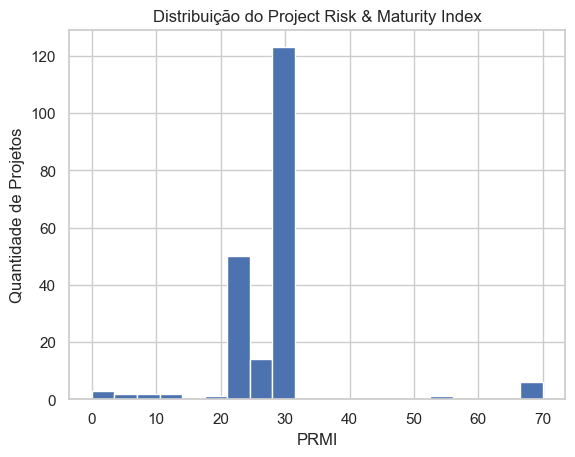

In [67]:
import matplotlib.pyplot as plt

plt.hist(df["PRMI"].dropna(), bins=20)
plt.title("Distribuição do Project Risk & Maturity Index")
plt.xlabel("PRMI")
plt.ylabel("Quantidade de Projetos")
plt.show()

In [69]:
df.sort_values("PRMI", ascending=False)[
    ["nome_completo", "PRMI"]
].head(10)

,nome_completo,PRMI
116,Educação Infantil - Município de Caxias do Sul...,70.000000
128,Aeroporto do Galeão/RJ,70.000000
78,Iluminação Pública - Saquarema (RJ),69.963850
137,PPP Novo Hospital do GHC,69.767069
49,Consórcio Mogiana,69.389966
159,TRENSURB: Metrô da Região Metropolitana de Por...,68.136551
206,Api test 1,55.995588
48,Parque Nacional do Caparaó/MG/ES,30.000000
20,Projeto Pontal - Mancha 20,30.000000
2,Canal de Acesso Aquaviário do Porto de Rio Gra...,30.000000


In [70]:
ranking_setor = (
    df.groupby("setor")["PRMI"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

ranking_setor

,setor,PRMI
0,Social Infrastructure,34.027745
1,Urban Services,31.756824
2,Water & Waste,28.640856
3,Transport,27.198909
4,Other,26.875177
5,Energy,24.497116


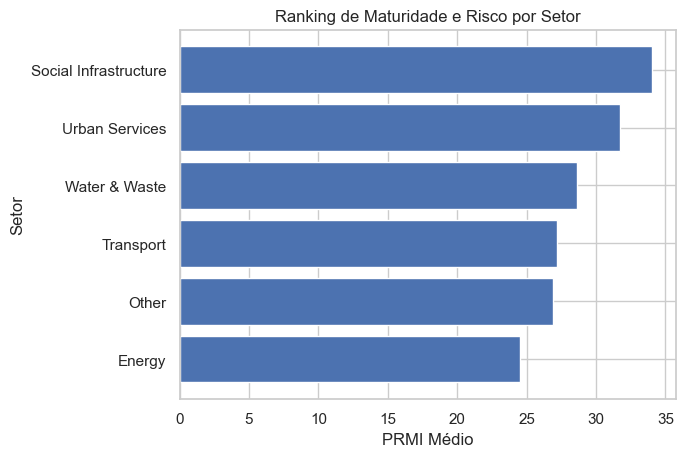

In [71]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(ranking_setor["setor"], ranking_setor["PRMI"])
plt.xlabel("PRMI Médio")
plt.ylabel("Setor")
plt.title("Ranking de Maturidade e Risco por Setor")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import folium

# Remover projetos sem coordenadas
df_map = df.dropna(subset=["latitude", "longitude", "PRMI"])

# Criar mapa centralizado no Brasil
mapa = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6,
        popup=f"""
        <b>Projeto:</b> {row['nome_projeto']}<br>
        <b>Setor:</b> {row['setor']}<br>
        <b>PRMI:</b> {round(row['PRMI'],2)}
        """,
        fill=True
    ).add_to(mapa)

mapa

In [ ]:
def cor_prmi(score):
    if score > 70:
        return "green"
    elif score > 40:
        return "orange"
    else:
        return "red"

mapa = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=7,
        color=cor_prmi(row["PRMI"]),
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['nome_projeto']} | PRMI: {round(row['PRMI'],2)}"
    ).add_to(mapa)

mapa

In [77]:
import folium

# Remover projetos sem coordenadas
df_map = df.dropna(subset=["latitude", "longitude"])

# Criar mapa centrado no Brasil
mapa_brasil = folium.Map(
    location=[-14.235, -51.9253], 
    zoom_start=4,
    tiles='OpenStreetMap'
)

# Adicionar marcadores para cada projeto
for idx, row in df_map.iterrows():
    # Usar cluster_com_custo se existir, senão usar um valor padrão
    valor = row.get('cluster_com_custo', 0)
    cor = 'red' if valor == 0 else 'orange' if valor == 1 else 'green'
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        popup=f"<b>{row['nome_projeto']}</b><br>Cluster: {valor}<br>Custo: R${row['custo_estimado']:,.0f}",
        color=cor,
        fill=True,
        fillColor=cor,
        fillOpacity=0.7
    ).add_to(mapa_brasil)

# Salvar mapa como arquivo HTML
mapa_brasil.save("mapa_projetos_ppi.html")
print("Mapa salvo como 'mapa_projetos_ppi.html'")

# Exibir mapa (se o notebook for confiável)
try:
    display(mapa_brasil)
except:
    print("Para visualizar o mapa interativo, abra o arquivo 'mapa_projetos_ppi.html' no navegador")

Mapa salvo como 'mapa_projetos_ppi.html'
